# Introduction

This demo provides the relevant Python code in order to apply the algorithm as described in the document: "Applying Machine-Learning Algorithms to Large Datasets of Galaxy Spectra: Finding Patterns and Detecting Outliers", by Guy Goren, with Prof. Dovi Poznanski as the advisor. The document is provided separately.


This demo focuses on the basic steps necessary to download the data set, perform feature engineering, apply the unsupervised Random Forest (RF) algorithm, and perform a basic analysis of the results. We'll use only a sample of 1000 objects from the SDSS DR14 in order to obtain the outputs quickly. When working with larger samples, it is highly suggested to run the heavy computations on a strong multi-core computer. Most of the functions are already parallelized.


**Let's start.**

# 0. Import

**Please make sure that you have all of the necessary packages installed.**

In [1]:
# Imports necessary for Jupyter Notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.manifold
from scipy.stats import describe
import urllib
import os
import multiprocessing as mp
from functools import partial
from itertools import compress
import warnings
from joblib import Parallel, delayed
from astropy.io import fits
import specutils.extinction
import sfdmap
from sklearn.preprocessing import Imputer
from scipy import signal
from functools import partial
from scipy.interpolate import interp1d
from time import time, sleep

# Import uRF_SDSS functions
from uRF_SDSS import *

# 1. Obtain the Spectra from SDSS DR14

## 1.1. Download Galaxies' Identifiers

** You can skip this step if desired, as the 'demo.csv' file should already be located in the 'db' folder under the working directory (from Git). **

1. Go to: [CasJobs](http://skyserver.sdss.org/CasJobs/)
    1. Create an account to the SciServer. ([here](https://apps.sciserver.org/login-portal/register?))
    2. Login to the SciServer. ([here](https://apps.sciserver.org/login-portal/login))
4. Go to: [CasJobs: Submit Job](http://skyserver.sdss.org/CasJobs/SubmitJob.aspx)
    1. Select 'DR14' under 'Context'.
    2. Submit the following query:
    ```sql
     SELECT TOP 2000
        specobjid, z, z_noqso, snMedian, run2d, ra, dec,
        plate, mjd, fiberid
     FROM SpecobjAll
     WHERE 
        class='GALAXY'
     ORDER BY snMedian DESC
        ```
        * The exact SQL query can be modified to obtain further details, such as photometry, spectral lines flux values, mass, and more.
        * The SDSS tables descriptions can be found at: [Schema Browser](http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx)
5. Go to: [MyDB](http://skyserver.sdss.org/CasJobs/MyDB.aspx)
    1. Download the demo table as Comma Separated Values (.csv)
    2. Move the .csv file downloaded to a folder named 'db' located at the working directory (where this notebook is located) and rename it as 'demo.csv'.

## 1.2. Load Galaxies' Identifiers as a Dataframe

In [2]:
dbPath = os.getcwd() + '\\db\\'
gs = pd.read_csv(dbPath + 'demo.csv', header=0)
gs.head()

,specobjid,z,z_noqso,snMedian,run2d,ra,dec,plate,mjd,fiberid
0,6910802875955257344,0.026050,0.026050,108.81650,v5_10_0,356.788330,15.596743,6138,56598,106
1,3377787487832350720,0.000049,0.000000,98.86369,104,162.985050,40.109464,3000,54843,319
2,1874677820647565312,0.016569,0.000000,98.10400,26,49.742075,41.470119,1665,52976,198
3,6910873794455248896,0.065718,0.065718,97.10170,v5_10_0,355.527890,15.024204,6138,56598,364
4,1874764682066159616,0.016749,0.000000,96.93578,26,49.964517,41.573585,1665,52976,514


## 1.3. Choose the Desired Sample

In [4]:
# Use z_noqso if possible
gs['z'] = [row['z_noqso'] if row['z_noqso']!=0 else row['z'] for i, row in gs.iterrows()]

# Remove galaxies with redshift z<=0.01
gs = gs[gs.z > 0.01]
gs.index = np.arange(len(gs))

# Choose the top n_obs median SNR objects
n_obs = 1000
gs = gs[:n_obs]

# Create links to their summary on the skyserver - it would be useful later
gs['url'] = ['http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=' + str(row['plate']).zfill(4) + '&mjd=' + str(row['mjd']) + '&fiber=' + str(row['fiberid']).zfill(4) for i, row in gs.iterrows()]

# Show DataFrame's head
gs.head().style.format({'url': make_clickable})

,specobjid,z,z_noqso,snMedian,run2d,ra,dec,plate,mjd,fiberid,url
0,6910802875955257344,0.0260504,0.0260504,108.817,v5_10_0,356.788,15.5967,6138,56598,106,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=6138&mjd=56598&fiber=0106
1,1874677820647565312,0.0165693,0,98.104,26,49.7421,41.4701,1665,52976,198,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=1665&mjd=52976&fiber=0198
2,6910873794455248896,0.0657183,0.0657183,97.1017,v5_10_0,355.528,15.0242,6138,56598,364,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=6138&mjd=56598&fiber=0364
3,1874764682066159616,0.0167486,0,96.9358,26,49.9645,41.5736,1665,52976,514,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=1665&mjd=52976&fiber=0514
4,1874756710606858240,0.0179093,0,94.1302,26,49.8614,41.5405,1665,52976,485,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=1665&mjd=52976&fiber=0485


**Let's see the redshift and SNR distributions**

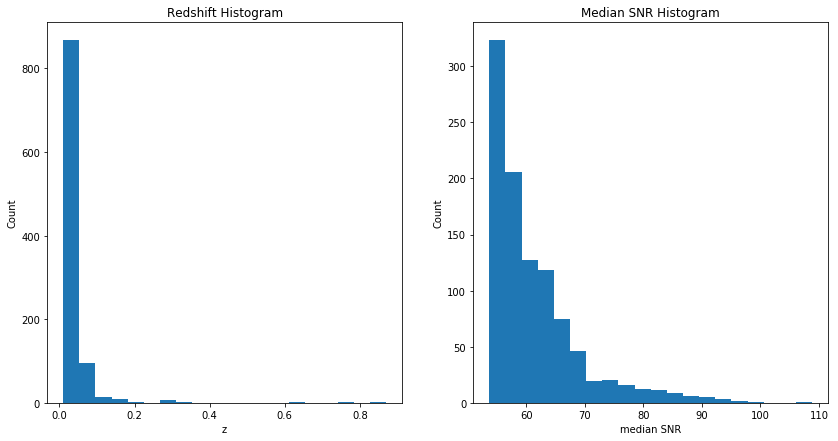

In [5]:
fig, axarr = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(14)

ax1 = axarr[0]
ax1.hist(gs.z, bins=len(gs)/50)
ax1.set_xlabel('z')
ax1.set_ylabel('Count')
ax1.set_title('Redshift Histogram')

ax2 = axarr[1]
ax2.hist(gs.snMedian, bins=len(gs)/50)
ax2.set_xlabel('median SNR')
ax2.set_ylabel('Count')
ax2.set_title('Median SNR Histogram')

plt.show()


## 1.4. Download .fits files

** You can skip this step if desired, as the .fits files should already be located in the 'db' folder under the working directory (from Git). **
<br>
** It might take up to 20 minutes. **

In [6]:
# Downloads .fits files from SDSS dr14 parallelly
getFitsFiles(gs, dbPath)

*** Getting  1000 fits files ****
  Done! Finished downloading .fits files	
  Failed to download: 1
  Time: 1000.59 [s]


**10 attempts are performed in order to download each .fits file.**
<br>
**Yet, if any there are any failed downloads, run it again.**
<br>
(don't worry, it will quickly download only the missing files)

## 1.5. Obtain E(B-V) Values

**First, we calculate the E(B-V) values for each galaxy, based on the dust map provided, by its (ra,dec)**
<br>
**If the dust maps weren't downloaded from Git, perform the following steps:**
1. Download the dust maps files from [here](https://github.com/kbarbary/sfddata).
2. Place the 4 files in '...\db\sfddata-master\' folder in your working directory, as in the Git repository.

In [7]:
# Calculate E(B-V) values for each galaxy (parallelly)
gs['ebv'] = calcEbv(gs, dbPath)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.9min finished


# 2. Obtain Spectra & Feature Engineering

**We obtain the spectra and perform most of the feature engineering with a single function**

In [8]:
# Obtaining the spectra, removing bad pixels, deredenning, de-redshift, 
# placing on the same grid, normalizing & smoothing (parallelly)
gs, specs, grid, specobjids = fitsToSpecs(gs, dbPath)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*** Getting Spectra from 1000 .fits files ***
  Getting data from .fits files... 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   53.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


    Done!
  Sorting and filtering results... 
    Done! Succeeded to get data from 1000 .fits files
  Calculating grid... 
    Grid min wavelength: 3774.27 [A]
    Grid max wavelength: 7060.47 [A]
    Number of features: 6573
    Done!
  Manipulating spectra... 


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.2s finished


    Done!
  Removing spectra with many NaNs...  Done! 991 spectra left... 
  Imputing NaNs...  Done!
  Done! Finished getting data from .fits files	Time: 67.28 [s]


## Removing the continuum

In [9]:
# Calculate the spectrum after its continuum was removed and the polynomial coefficients used for the fit
specs_no_cont, poly_coefs = remove_cont(specs, grid)

** Let's see how a random spectrum looks like before and after removing the continuum **

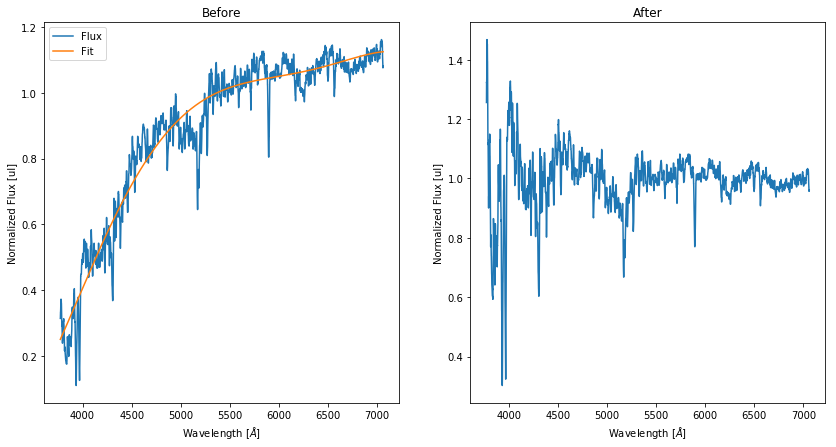

In [10]:
ix = np.random.randint(0, len(gs))

fig, axarr = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(14)

ax1 = axarr[0]
ax1.plot(grid, specs[ix], label='Flux')
ax1.plot(grid, np.poly1d(poly_coefs[ix])(grid), label='Fit')
ax1.set_xlabel('Wavelength [$\AA$]')
ax1.set_ylabel('Normalized Flux [ul]')
ax1.set_title('Before')
ax1.legend()

ax2 = axarr[1]
ax2.plot(grid, specs_no_cont[ix])
ax2.set_xlabel('Wavelength [$\AA$]')
ax2.set_ylabel('Normalized Flux [ul]')
ax2.set_title('After')

plt.show()

# 3. Unsupervised Random Forest (RF)

## 3.1. Perpare RF's input

In [11]:
# Create synthetic data
specs_no_cont_syn = return_synthetic_data(specs_no_cont)

# Merge real and synthetic data and label them
X, y = merge_work_and_synthetic_samples(specs_no_cont, specs_no_cont_syn)

** How a random synthetic object looks like? **

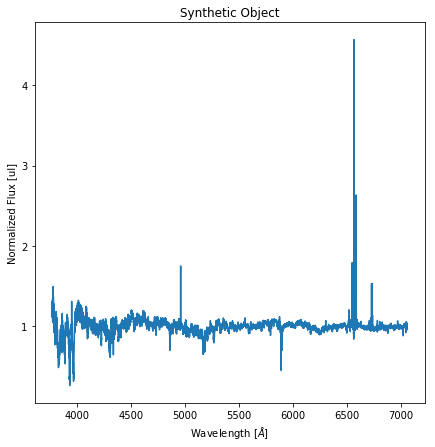

In [12]:
ix = np.random.randint(0, len(gs))

plt.figure(figsize=(7,7))
plt.plot(grid, specs_no_cont_syn[ix])
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Normalized Flux [ul]')
plt.title('Synthetic Object')
plt.show()

## 3.2. Fit RF

In [13]:
# Set RF hyperparameters
n_est = 100
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_est,
                                                     max_features=len(grid)/5,
                                                     min_samples_split=10,
                                                     n_jobs=-1,
                                                     verbose=1)
# Fit RF classifier
rf.fit(X, y)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1314, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

** How good is the classification? **

In [14]:
real_prob = rf.predict_proba(specs_no_cont)[:,0]
print 'Mean probability of a real object to be classified as real: %.3f' % np.mean(real_prob)

syn_prob = rf.predict_proba(specs_no_cont_syn)[:,1]
print 'Mean probability of a synthetic object to be classified as synthetic : %.3f' % np.mean(syn_prob)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Mean probability of a real object to be classified as real: 0.945


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Mean probability of a synthetic object to be classified as synthetic : 0.923


## 3.3 Visualizing the Forest

** How deep are the trees? **

DescribeResult(nobs=100L, minmax=(9, 46), mean=21.12, variance=56.187474747474745, skewness=0.8836817063267862, kurtosis=0.5955377659926913)


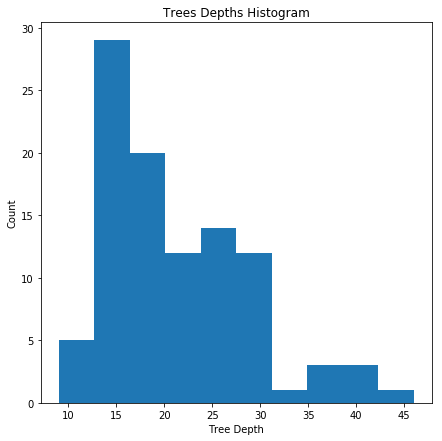

In [15]:
# Calculate trees' depths
trees_depths = [est.tree_.max_depth for est in rf.estimators_]

# Print Statistics
print describe(trees_depths)

# Plot histogram
plt.figure(figsize=(7,7))
plt.hist(trees_depths, bins=n_est/10)
plt.title('Trees Depths Histogram')
plt.xlabel('Tree Depth')
plt.ylabel('Count')
plt.show()

** How many observations are there in the leafs? **

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


DescribeResult(nobs=4509L, minmax=(1.0, 941.0), mean=38.18097139055223, variance=9455.66333792043, skewness=5.325256758391032, kurtosis=33.26709825454077)


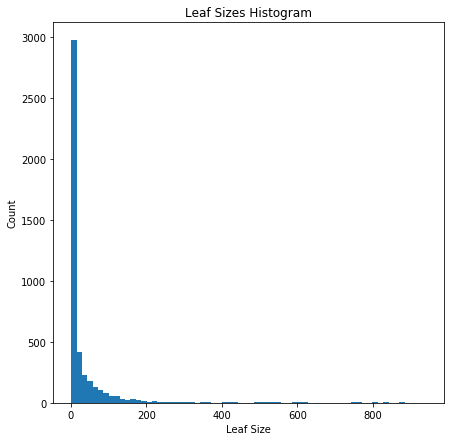

In [16]:
# Calculate leafs' sizes
leafs_sizes = get_leaf_sizes(rf, specs_no_cont)
        
# Print Statistics
print describe(leafs_sizes)

# Plot histogram
plt.figure(figsize=(7,7))
plt.hist(leafs_sizes, n_est*(2*len(gs))/3000)
plt.title('Leaf Sizes Histogram')
plt.xlabel('Leaf Size')
plt.ylabel('Count')
plt.show()

## 3.4. Calculate Dissimilarity Matrix

In [17]:
dis_mat = calcDisMat(rf, specs_no_cont)

  Applying forest to results... 
  Max leaf index:  172
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 984 out of 991 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 991 out of 991 | elapsed:   20.0s finished


# 4. Analyze Results

## 4.1. Visualize with t-SNE

### Calculate t-SNE map based on the dissimilarity matrix

In [18]:
sne = sklearn.manifold.TSNE(n_components=2, perplexity=25, metric='precomputed', verbose=1).fit_transform(dis_mat)

sne_f1 = sne[:, 0]
sne_f2 = sne[:, 1]

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 991 samples in 0.002s...
[t-SNE] Computed neighbors for 991 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 991 / 991
[t-SNE] Mean sigma: 0.138231
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.356171
[t-SNE] Error after 1000 iterations: 1.541265


### Plot t-SNE Map

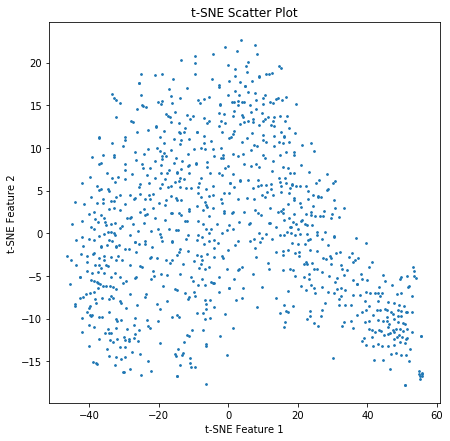

In [19]:
plt.figure(figsize=(7,7))
plt.scatter(sne_f1, sne_f2, s=3)
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Scatter Plot')
plt.show()

** Let's color it by the average color ($\bar{\lambda}$)**

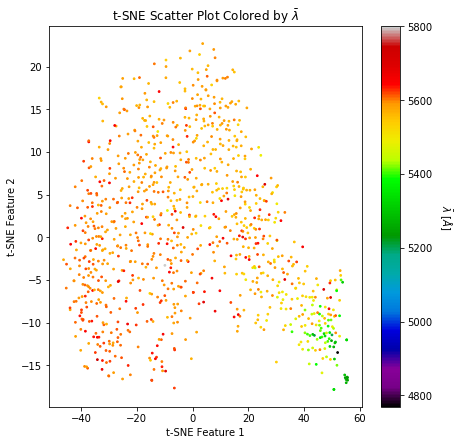

In [20]:
# First, we must calculate the average color.
# notice that we use the spectrum before the continuum was removed.
gs['avg_clr'] = np.array([np.average(grid, weights=x) for x in specs])

# t-SNE Scatter plot zoomed in colored by the average color.
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
im_scat = ax1.scatter(sne_f1, sne_f2, s=3, c=gs.avg_clr, cmap=plt.cm.get_cmap('nipy_spectral'))
ax1.set_xlabel('t-SNE Feature 1')
ax1.set_ylabel('t-SNE Feature 2')
ax1.set_title(r't-SNE Scatter Plot Colored by $\bar{\lambda}$')

clb = fig.colorbar(im_scat, ax=ax1)
clb.ax.text(3,0.5, r'$\bar{\lambda}$ [$\AA$]', rotation=270)

plt.show()

## 4.2. Outlies

### Calculate Weirdness Scores

In [21]:
w_n = 10
gs['w'] = np.array([np.mean(np.partition(np.delete(row, 0), w_n)[:w_n]) for row in dis_mat])

** Weirdness Scores Distribution **

DescribeResult(nobs=100L, minmax=(9, 46), mean=21.12, variance=56.187474747474745, skewness=0.8836817063267862, kurtosis=0.5955377659926913)


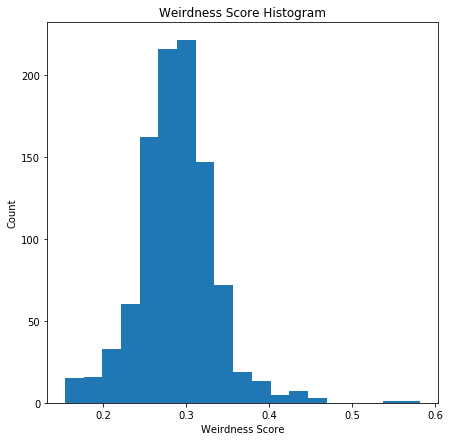

In [22]:
# Print Statistics
print describe(trees_depths)

# Plot histogram
plt.figure(figsize=(7,7))
plt.hist(gs.w, len(gs)/50)
plt.title('Weirdness Score Histogram')
plt.xlabel('Weirdness Score')
plt.ylabel('Count')
plt.show()

### Top outliers

In [23]:
# Top outliers indices
ol_ixs = np.argsort(gs.w)[::-1]

** Let's see the 10 weirdest galaxies **

In [24]:
gs.iloc[ol_ixs[:10]].style.format({'url': make_clickable}) # The url column is now clickable, so it's easy to inspect them

,specobjid,z,z_noqso,snMedian,run2d,ra,dec,plate,mjd,fiberid,url,ebv,spec_median,avg_clr,w
726,3089623622554249216,0.0137809,0,55.9006,26,211.593,16.4834,2744,54272,561,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=2744&mjd=54272&fiber=0561,0.0172041,239.02,5539,0.582031
306,1875854848096757760,0.015452,0,62.8005,26,48.967,41.8575,1666,52991,384,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=1666&mjd=52991&fiber=0384,0.131512,145.766,5552.94,0.54834
597,7192505721602154496,0.0517395,0.0517395,57.4515,v5_10_0,118.184,45.9493,6388,56309,935,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=6388&mjd=56309&fiber=0935,0.0707644,100.608,5575.56,0.467285
608,749937609819580416,0.0176428,0,57.2656,26,29.9353,-7.83915,666,52149,321,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=0666&mjd=52149&fiber=0321,0.0213093,83.3976,5567.51,0.464355
498,439132331626752000,0.0634929,0,58.7813,26,5.90703,-0.509809,390,51900,114,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=0390&mjd=51900&fiber=0114,0.0222257,84.2625,5535.36,0.451172
414,609180327067281408,0.0604429,0,60.1499,26,113.61,31.7601,541,51959,249,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=0541&mjd=51959&fiber=0249,0.0375226,72.9148,5564.7,0.445068
10,1874695412833609728,0.0188492,0,89.7101,26,49.1791,41.3249,1665,52976,262,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=1665&mjd=52976&fiber=0262,0.139696,266.958,5539.76,0.440918
369,5626239578505453568,0.0340696,0.0340696,61.1943,v5_10_0,256.283,30.4032,4997,55738,428,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=4997&mjd=55738&fiber=0428,0.0411789,81.3943,5597.09,0.436035
396,5034106935185481728,0.0292111,0.0292111,60.5984,v5_10_0,120.017,23.4379,4471,55617,758,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=4471&mjd=55617&fiber=0758,0.0493981,88.449,5644,0.434814
252,6081099845874982912,0.0250812,0.0250812,64.1138,v5_10_0,186.618,9.01985,5401,55949,416,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=5401&mjd=55949&fiber=0416,0.0214575,81.552,5699.61,0.429932


## 4.3. Finding Similar Objects

** Let's look for a galaxy which is the most similar to a random galaxy **

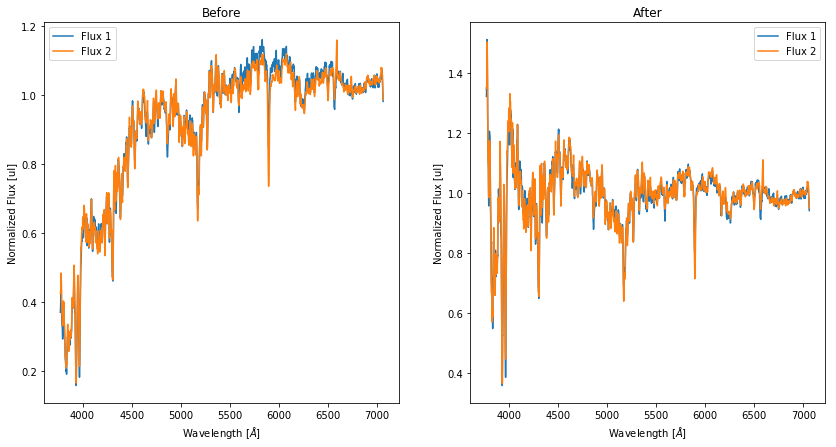

,specobjid,z,z_noqso,snMedian,run2d,ra,dec,plate,mjd,fiberid,url,ebv,spec_median,avg_clr,w
779,5273866450955640832,0.0545698,0.0545698,55.388,v5_10_0,131.327,44.5277,4684,56226,550,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=4684&mjd=56226&fiber=0550,0.022531,89.0422,5588.64,0.302979
96,532574327799834624,0.0170264,0,71.5458,26,140.009,1.03827,473,51929,86,http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?plate=0473&mjd=51929&fiber=0086,0.0230477,194.458,5583.18,0.244385


In [25]:
# Draw a random galaxy
ix = np.random.randint(0, len(gs))

# Find its nearest neighbor
ix_sim = np.argsort(dis_mat[ix])[1]

# Plot both spectrum before & after removing the continuum

fig, axarr = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(14)

ax1 = axarr[0]
ax1.plot(grid, specs[ix], label='Flux 1')
ax1.plot(grid, specs[ix_sim], label='Flux 2')
ax1.set_xlabel('Wavelength [$\AA$]')
ax1.set_ylabel('Normalized Flux [ul]')
ax1.set_title('Before')
ax1.legend()

ax2 = axarr[1]
ax2.plot(grid, specs_no_cont[ix], label='Flux 1')
ax2.plot(grid, specs_no_cont[ix_sim], label='Flux 2')
ax2.set_xlabel('Wavelength [$\AA$]')
ax2.set_ylabel('Normalized Flux [ul]')
ax2.set_title('After')
ax2.legend()

plt.show()

## Show their details
gs.iloc[[ix, ix_sim]].style.format({'url': make_clickable})